# **Image Classification of Caltech101 Dataset( Histogram Data )**.<br>
### **Requirements:**<br>
`Images.csv`: Contains the images which are represented by an image ID and the corresponding
class.<br>
`EdgeHistogram.csv`: Contains the feature data for the Edge Histogram feature for the images (Dimension of 80).

### **installation and Deployment**
For a local installation, make sure you have pip installed and run:<br>
    
    pip install notebook
**Note**: Use conda environment to ease up the setup and future environment setups.

    conda create --name <envname> --file requirements.txt
    conda activate testing
Install the necessary dependencies:

    python -m pip install -r requirements.txt

Running in a local installation
Launch with:

    jupyter notebook 

if using google colab: Just run the cells.

### **Dataset Distribution:**.

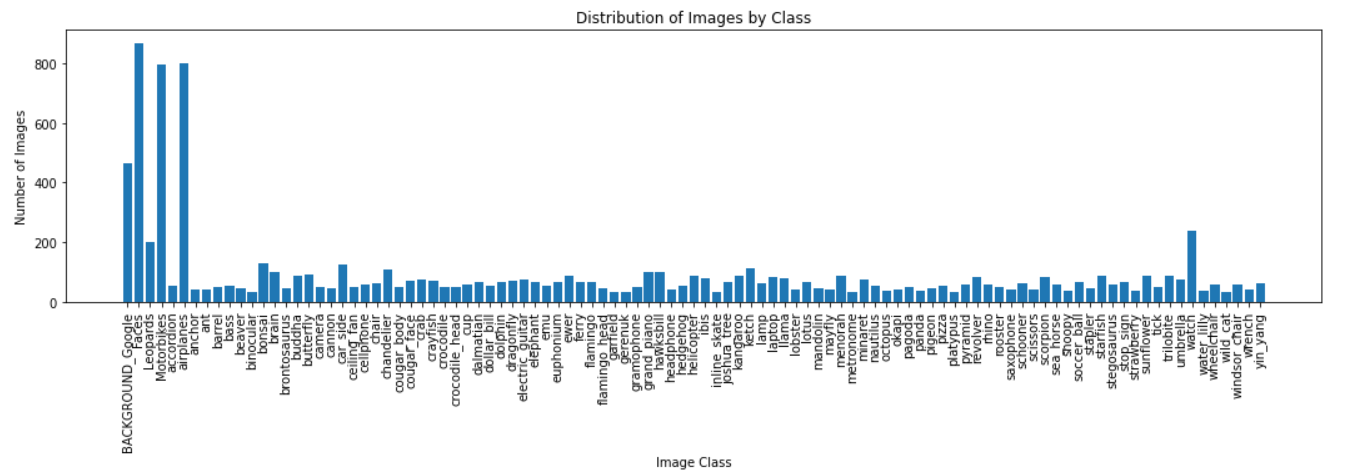

We can clearly see that Faces category has the highest number of images as 870. And the lowest number of images as low as 31. Such an imbalanced dataset is one of the major reasons for the bad performance of deep neural networks and other general classifiers.

### **Run Strategies:**.
1. `Run Classifiers with K-fold Strategy(Training|Testing).`
2. `Run Classifiers with Stratified K-fold Strategy(Training|Testing).` 
3. `Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training.`

for the options 1 and 2, below classifiers used and performance is observed:
1. `Multi-layer Perceptron (MLP).`
2. `SVM Classification.`
3. `RandomForestClassifier.`
4. `KNN Classifier.`
5. `Logistic Regression Classifier.`

**Dataset consideration**
1. **Original Dataset**

Some Observations

`Option 1:`
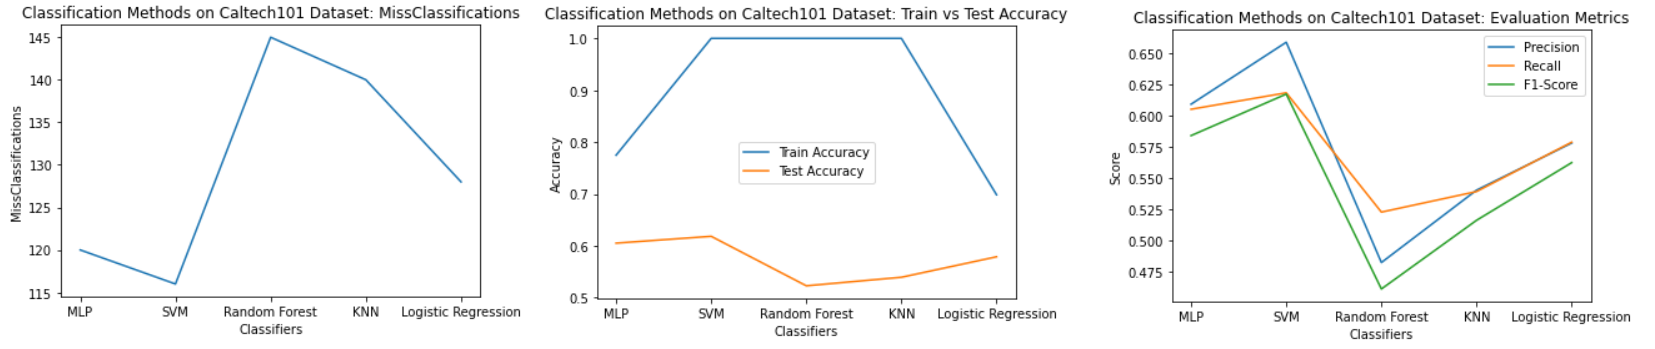
`Option 2:`
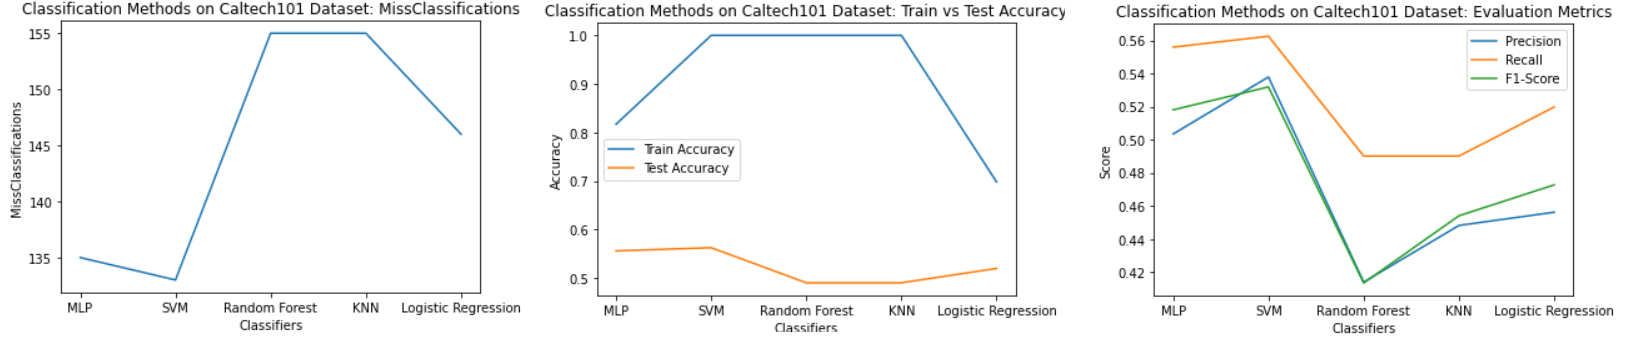
`Option 3:`
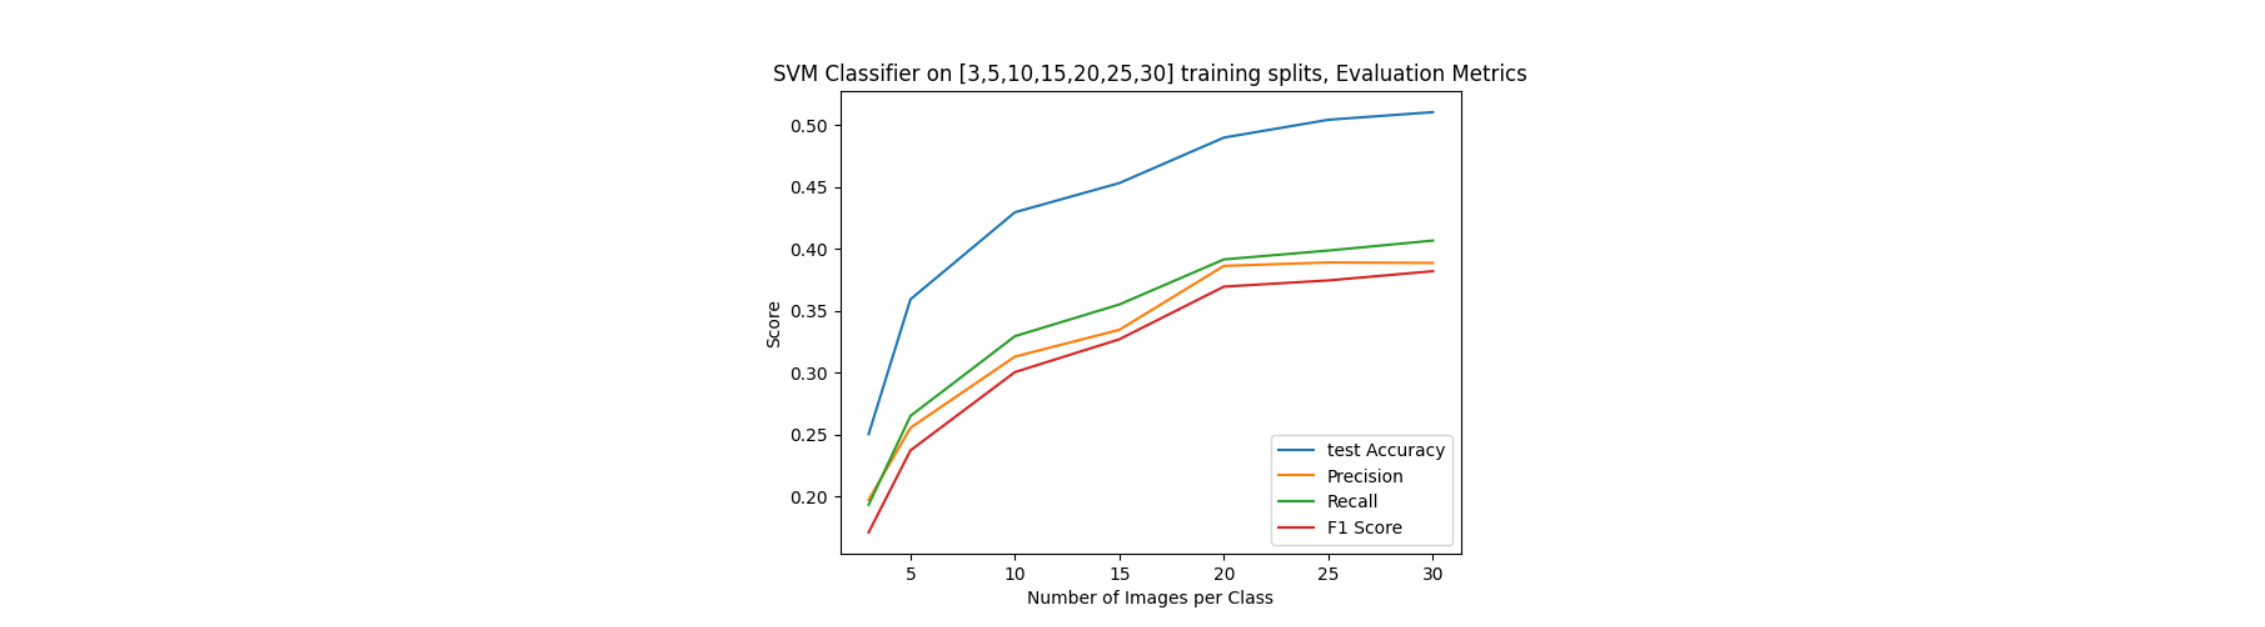

2. **Dataset after Removing the `BACKGROUND_Google` Class.**(noise class).

If we ignore the BACKGROUND_Google label and its images, then we have 8677 images in total. Now, these are not enough images to get very high accuracy, but it increases the accuracy slightly.

Some Observations

`Option 1:`
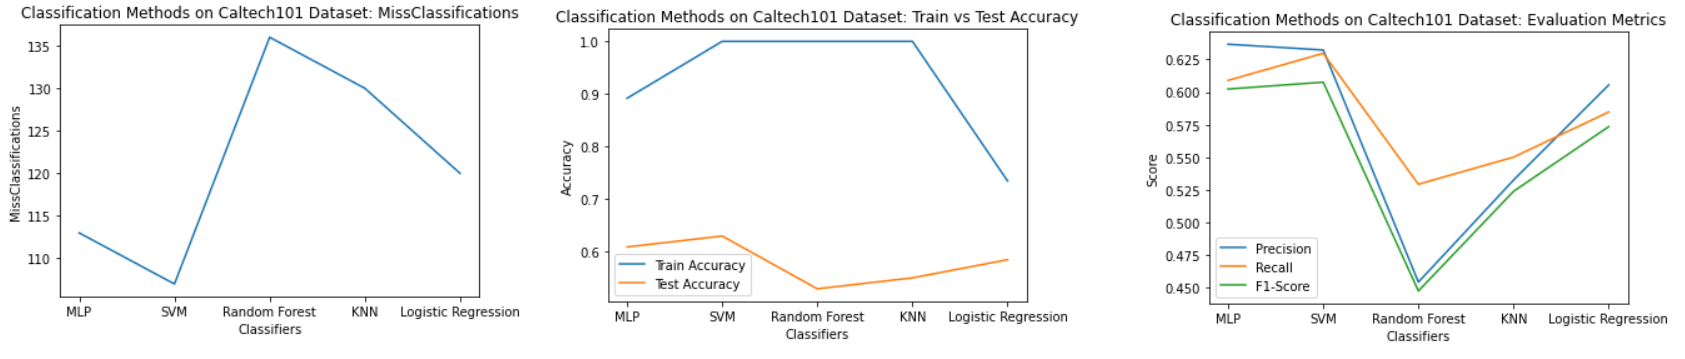
`Option 2:`
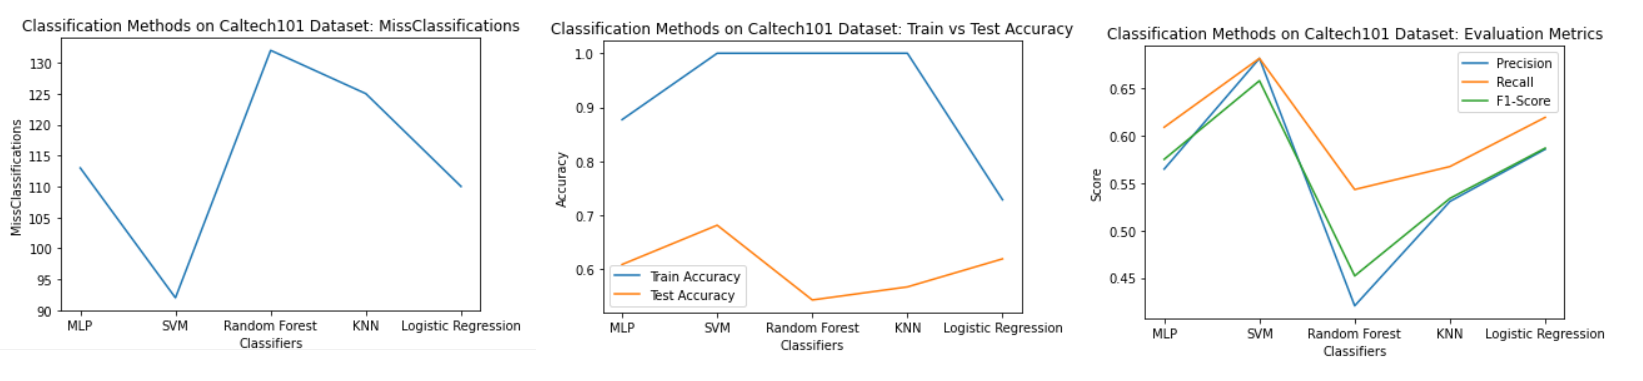
`Option 3:`
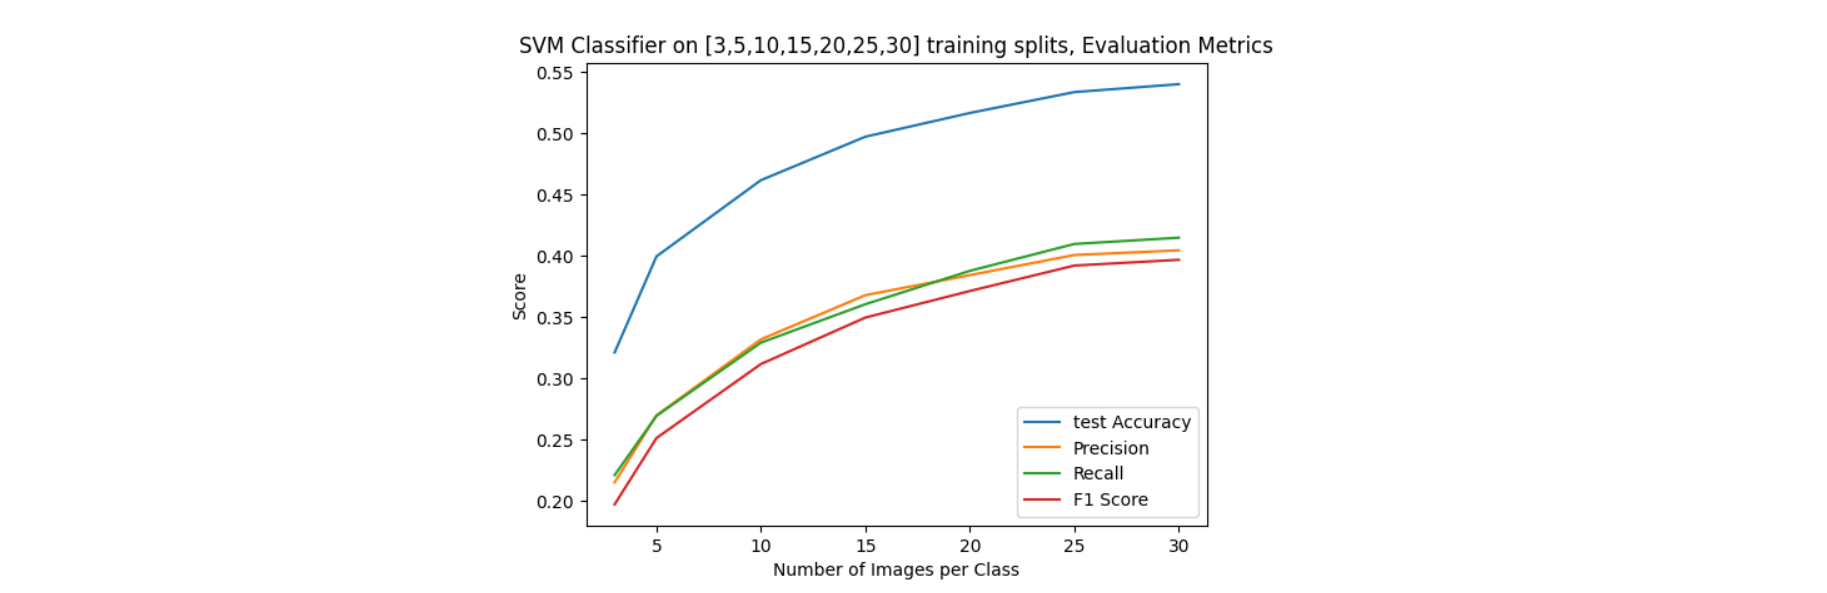

`Clearly from above observations removing the noise class is improving the classifier performance.`





In [60]:
import os
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve, log_loss, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import csv
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import time
from sklearn import svm
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []

In [67]:
with open('Images.csv', 'r') as f:
    # Read the first line of the file to get the number of images | Firstline Escaper
    num_images = int(f.readline())
    # Initialize lists to store the image IDs and classes
    image_ids = []
    image_classes = []
    # Create a csv reader
    reader = csv.reader(f, delimiter=';')
    # Iterate through each row
    for row in reader:
        # The first column is the image ID
        image_ids.append(row[0])
        # The second column is the class
        image_classes.append(row[1])

In [68]:
histogramDatas = []
with open('EdgeHistogram.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    # Read the first line of the file to get the edge histograms| Firstline Escaper
    next(reader)
    for row in reader:
        feature_vector = [float(x) for x in row[1:]]
        histogramDatas.append(feature_vector)

# Convert the list of edge histograms to a numpy array
histogramData = np.array(histogramDatas)
image_classes= np.array(image_classes)

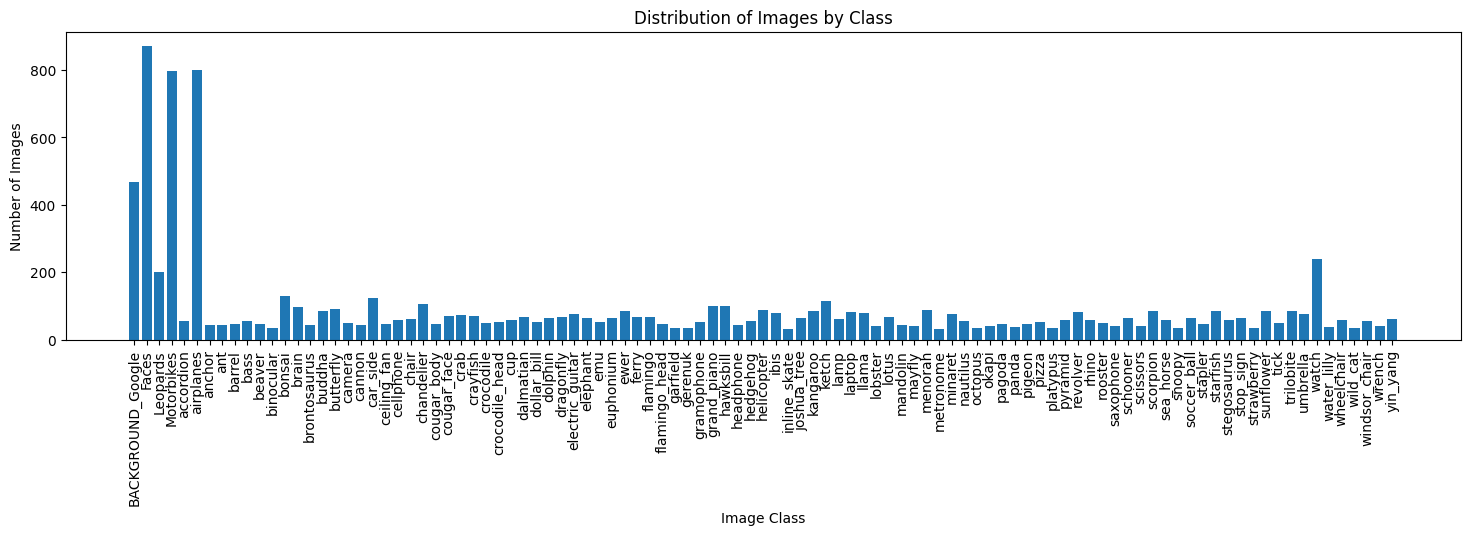

In [53]:
# identifying the class frequency and plotting the same.
unique_labels, counts = np.unique(image_classes, return_counts=True)
fig = plt.figure(figsize=(18,4))
plt.bar(unique_labels, counts)
plt.xlabel('Image Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Class')
plt.xticks(rotation=90)
plt.yticks()
plt.show()

In [7]:
def edge_histogram_to_image(feature_vector, width, height):
    # Normalize the feature vector between 0 and 255.
    # Dont know how Edge Histogram created in first place so using this right now.
    minVal = min(feature_vector)
    maxVal = max(feature_vector)
    feature_vector = [(x - minVal) / (maxVal - minVal) * 255 for x in feature_vector]
    # Convert the feature vector to a grayscale image
    img = Image.new('L', (width, height))
    img.putdata(feature_vector)
    return img

def plot_sample(x, y, index):
    img = edge_histogram_to_image(x[index], 10, 8)
    plt.figure(figsize = (5,2))
    plt.imshow(img, cmap='gray')
    plt.xlabel(y[index])
    plt.show()

**Function to Calculate Train and test accuracy**

In [8]:
def  acc_find(clf,clfLabel,X_train, X_test, y_train, y_test):
  classifiers.append(clfLabel)
  train_accuracy = clf.score(X_train, y_train)
  train_acc.append(train_accuracy)
  # Compute the accuracy on the validation set
  test_accuracy = clf.score(X_test, y_test)
  test_acc.append(test_accuracy)
  print("Train Accuracy for {} is: {} ".format(clfLabel,train_accuracy))
  print("Test Accuracy for {} is: {}".format(clfLabel,test_accuracy))

**Function to Calculate Precision, Recall, fscore**

In [9]:
def  precision_recall_fscore_find(clf,X_train, X_test, y_train, y_test):
  # Predict the labels of the test data
  y_pred = clf.predict(X_test)

  # Calculate precision, recall, F1-score, and support
  precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  # Print the results
  precisions.append(precision)
  print("Precision:", precision)
  recalls.append(recall)
  print("Recall:", recall)
  f1_scores.append(fscore)
  print("F1-score:", fscore)

**Function to Find the no of Miss Classifications on each classification Method**

In [10]:
def findMissClassification(clf,clfmethod,X_test,y_test):
  classifiersMiss.append(clfmethod)
  pred = clf.predict(X_test)
  num_wrong_cls = np.sum(pred != y_test)
  num_wrong_clss.append(num_wrong_cls)
  print("Number of images incorrectly classified for {} is: {}".format(clfmethod,num_wrong_cls))

**Function to find Top 3 Incorrect Classifications and plotting them**

In [11]:
def incorrect_top_3(clf,X_test, y_test):
  print("Top 3 Miss-Classified Classes.")
  pred = clf.predict(X_test)
  incorrect_pred = pred != y_test
  incorrect_idx = np.where(incorrect_pred == True)
  top_three = incorrect_idx[0][:3]
  plt.figure(figsize = (10, 10))
  for i, idx in enumerate(top_three):
      plt.subplot(5,1,i + 1),plt.imshow(edge_histogram_to_image(X_test[idx],10,8),cmap = 'gray')
      plt.title('Actual {} | Predicted: {}'.format(y_test[idx], pred[idx])), plt.xticks([]), plt.yticks([])
  plt.show()

### **Noise Class removal**

"BACKGROUND_Google" is found to a noise class if need to remove it we can use the below function.

**Note**: Without "BACKGROUND_Google" found an increase in test accuracy and decrease in missclassification count

In [13]:
def class_remove(class_to_remove, image_classes, histogramData):
  # Find the indices of the histograms that belong to the class to be removed
  indices_to_remove = np.where(image_classes == class_to_remove)

  # Remove the histograms and their corresponding labels
  histogramData = np.delete(histogramData, indices_to_remove, axis=0)
  image_classes = np.delete(image_classes, indices_to_remove)
  return histogramData, image_classes
nmrClassess=len(np.unique(image_classes))

### **K-fold cross validation**: 

This method involves dividing the dataset into k subsets, where k-1 subsets are used for training and the remaining subset is used for testing. This method is useful for evaluating the model's performance and identifying overfitting.

In [15]:
def kfoldDivision(splits):
  kf = KFold(n_splits=splits, shuffle=True, random_state=42)
  for train_index, test_index in kf.split(histogramData):
      X_train, X_test = histogramData[train_index], histogramData[test_index]
      y_train, y_test = image_classes[train_index], image_classes[test_index]
  return X_train, X_test, y_train, y_test


### **Stratified k-fold**: 

is a technique for cross-validation in machine learning where the data is divided into k folds, and the folds are created such that each fold contains roughly the same proportions of the different classes in the data. This is used to ensure that each fold is representative of the overall distribution of the data and to prevent any bias in the training or evaluation of the model.

In [16]:
def stratifiedKFoldDivision(splits):
  skf = StratifiedKFold(n_splits=splits,shuffle=True,random_state=18)#42 good 18+24
  for train_index, test_index in skf.split(histogramData,image_classes):
      X_train, X_test = histogramData[train_index], histogramData[test_index]
      y_train, y_test = image_classes[train_index], image_classes[test_index]
  return X_train, X_test, y_train, y_test

### **ANN Classifier: Multi-layer Perceptron (MLP)**

A Multi-layer Perceptron (MLP) is a type of artificial neural network that is often used for supervised learning tasks such as classification and regression. It consists of multiple layers of interconnected "neurons," which process and transmit information through the network.

An MLP classifier is made up of an input layer, one or more hidden layers, and an output layer. The input layer receives the input features, and each neuron in the hidden and output layers performs a computation on the input and produces an output. The computations involve a set of weights and biases, which are learned during the training process in order to make accurate predictions.

MLP classifiers are particularly useful for problems with complex, non-linear decision boundaries. They are also able to capture interactions between features, and can handle high-dimensional input spaces.

**Note:** loss difference in a machine learning model typically refers to the difference in error or performance between the model's predicted output and the actual output. A lower loss value indicates better performance and a higher loss value indicates worse performance. 

In [17]:
def MLPClassifierTrial(X_train, X_test, y_train, y_test):
  print("Multi-layer Perceptron Classification.")
  mlp = MLPClassifier(activation='relu', 
                      alpha=1,  
                      random_state=56,
                      hidden_layer_sizes=(80, 120, nmrClassess),
                      max_iter=1000)
  mlp.solver='adam' #change accordingly , 'lbfgs', 'sgd', 'adam'
  mlp.fit(X_train, y_train)
  acc_find(mlp,'MLP',X_train, X_test, y_train, y_test)
  findMissClassification(mlp,'MLP', X_test, y_test)
  precision_recall_fscore_find(mlp,X_train, X_test, y_train, y_test)
  # Compute loss on the training set
  train_loss = mlp.loss_

  # Compute loss on the test set
  labels = np.unique(mlp.predict(X_train))
  test_loss = log_loss(y_test, mlp.predict_proba(X_test), labels=labels)
  print('Loss difference observed Between train/test:',test_loss-train_loss)
  incorrect_top_3(mlp,X_test, y_test)
  y_pred = mlp.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

In [83]:
def mlpGridSearch(X_train, X_test, y_train, y_test):
  print("Multi-layer Perceptron GridSearch Classification.")
  # Define MLP classifier
  mlp = MLPClassifier()
  
  # Define hyperparameters and possible values to tune
  param_grid = {
      'hidden_layer_sizes': [(80,120,nmrClassess), (80,100,nmrClassess), (160,150,nmrClassess)],
      'activation': ['relu', 'tanh', 'logistic'],
      'solver': ['adam'],
      'learning_rate': ['constant', 'invscaling', 'adaptive'],
      'alpha': [0.0001, 0.001, 0.01],
      'learning_rate_init': np.logspace(-5, 0, 5)
  }
  
  # Initialize GridSearchCV with the classifier and hyperparameters
  grid_search = GridSearchCV(mlp, param_grid, cv=5)

  # Fit GridSearchCV on the training data
  grid_search.fit(X_train, y_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  print("Best values:",best_params)

  # Train a MLP classifier with the best hyperparameters on the entire training data
  best_mlp = MLPClassifier(**best_params)
  best_mlp.fit(X_train, y_train)

  acc_find(best_mlp,'mlp_Grid',X_train, X_test, y_train, y_test)
  findMissClassification(best_mlp,'mlp_Grid',X_test, y_test)
  precision_recall_fscore_find(best_mlp,X_train, X_test, y_train, y_test)
  y_pred = best_mlp.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

### **SVM Classification**:

Support Vector Machines (SVMs) are a type of supervised learning algorithm that can be used for classification or regression tasks. The idea behind SVMs is to find the best boundary (or "hyperplane") that separates the different classes in the data.

In a SVM classifier, the algorithm finds the hyperplane that maximizes the margin, which is the distance between the hyperplane and the closest data points from each class. These closest data points are called "support vectors" and have a crucial role in defining the position of the hyperplane.

SVMs have several advantages over other algorithms, such as:

*   They work well with high-dimensional data, and can handle a large number of features.
*   They are effective in cases where the number of features is greater than the number of samples.
*   They can handle non-linearly separable data by transforming the input space into a higher dimensional space where a linear hyperplane can be used to separate the classes.

**svmGridSearch**

function to perform elbow method to find best param for 'C' and it uses a stratified K-Fold.


In [18]:
def svmClassifierPlusGridtrial(X_train, X_test, y_train, y_test):
  print("Support Vector Machines (SVMs) Classification.")
  svmClassifier = svm.SVC(kernel='rbf', C=100, shrinking=False, gamma='scale')
  # fit the classifier to the histogram and labels data
  svmClassifier.fit(X_train, y_train)
  findMissClassification(svmClassifier,'SVM', X_test,  y_test)
  acc_find(svmClassifier,'SVM',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(svmClassifier,X_train, X_test, y_train, y_test)
  incorrect_top_3(svmClassifier, X_test, y_test)
  y_pred = svmClassifier.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)


In [85]:
def svmGridSearch(X_train, X_test, y_train, y_test):
  # Define the range of values for C to test
  param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'kernel': ['linear', 'rbf'],
                'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
                'shrinking': [True, False]}

  # Define the SVM model
  svms = svm.SVC()

  # Use GridSearchCV to perform k-fold cross-validation with 5 folds
  grid_search = GridSearchCV(svms, param_grid, cv=5,return_train_score=True)
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("Best values:",best_params)
  # Train a MLP classifier with the best hyperparameters on the entire training data
  best_svm = svm.SVC(**best_params)
  best_svm.fit(X_train, y_train)

  acc_find(best_svm,'SVM_grid',X_train, X_test, y_train, y_test)
  findMissClassification(best_svm,'SVM_grid',X_test, y_test)
  precision_recall_fscore_find(best_svm,X_train, X_test, y_train, y_test)
  y_pred = best_svm.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

In [54]:
def svmTrainingDivision(images_per_class):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(histogramData, image_classes, test_size=0.25, random_state=42)

  # Initialize lists to store the results
  accuracies = []
  precisions = []
  recalls = []
  f1s = []

  # Loop over the different number of images per class
  for num_images in images_per_class:
      # Split the training set into subsets with the desired number of images per class
      indices = np.array([], dtype=int)
      for label in np.unique(y_train):
          label_indices = np.where(y_train == label)[0]
          indices = np.concatenate((indices, label_indices[:num_images]))
      X_train_subset, y_train_subset = X_train[indices], y_train[indices]
      svmClassifier = svm.SVC(kernel='rbf', C=100, shrinking=False, gamma=.0025) 
      svmClassifier.fit(X_train_subset, y_train_subset)
      # Evaluate the model on the test set
      y_pred = svmClassifier.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

      # Store the results
      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1s.append(f1)

  # Plot the results
  plt.plot(images_per_class, accuracies, label='test Accuracy')
  plt.plot(images_per_class, precisions, label='Precision')
  plt.plot(images_per_class, recalls, label='Recall')
  plt.plot(images_per_class, f1s, label='F1 Score')
  plt.xlabel('Number of Images per Class')
  plt.ylabel('Score')
  plt.legend()
  plt.title('SVM Classifier on [3,5,10,15,20,25,30] training splits, Evaluation Metrics')
  plt.show()

options = {1: kfoldDivision, 2: stratifiedKFoldDivision, 3: svmTrainingDivision}

### **RandomForestClassifier**

Random Forest is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [19]:
# Train and test Random Forest classifier
def randomForestClassifierTrial(X_train, X_test, y_train, y_test):
  print("Random Forest Classifier.")
  rf = RandomForestClassifier(max_depth=None, n_estimators=500, min_samples_split=2, min_samples_leaf=1, random_state=12)
  rf.fit(X_train, y_train)
  findMissClassification(rf,'Random Forest',X_test,  y_test)
  acc_find(rf,'Random Forest',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(rf,X_train, X_test, y_train, y_test)
  incorrect_top_3(rf, X_test,  y_test)
  y_pred = rf.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

In [87]:
def RandomForestGridSearch(X_train, X_test, y_train, y_test):
  # Define the grid of hyperparameters to search
  param_grid = {
      'n_estimators': [10, 50, 100, 500],
      'max_depth': [None, 5, 10, 20],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  # Initialize the classifier
  rf = RandomForestClassifier()

  # Use GridSearchCV to find the best hyperparameters
  
  grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(X_train, y_train)

  # Get the best hyperparameters
  best_params = grid_search.best_params_
  print("Best values:",best_params)

  # Train a MLP classifier with the best hyperparameters on the entire training data
  best_RF = RandomForestClassifier(**best_params)
  best_RF.fit(X_train, y_train)

  acc_find(best_RF,'RF_grid',X_train, X_test, y_train, y_test)
  findMissClassification(best_RF,'RF_grid',X_test, y_test)
  precision_recall_fscore_find(best_RF,X_train, X_test, y_train, y_test)
  y_pred = best_RF.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

### **KNN Classifier**

KNN, or k-Nearest Neighbors, is a simple yet powerful classification and regression algorithm. The basic idea behind the KNN algorithm is to find the k-number of closest data points (neighbors) to a given data point, and then predict the class or value of that point based on the majority class or average value of its k-nearest neighbors.

The KNN algorithm is sensitive to the scale of the data.

In [20]:
# Train and test KNN classifier
def knnClassifierTrial(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier(weights='distance',n_neighbors=5, p=1)
  knn.n_neighbors=1
  knn.fit(X_train, y_train)
  findMissClassification(knn,'KNN', X_test, y_test)
  acc_find(knn,'KNN',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(knn,X_train, X_test, y_train, y_test)
  incorrect_top_3(knn,X_test,  y_test)
  y_pred = knn.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

In [89]:
def KNNGridSearch(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier()

  # Define the parameter grid
  param_grid = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]}

  # Create a GridSearchCV object
  grid_search = GridSearchCV(knn, param_grid, cv=5)

  # Fit the GridSearchCV object to the training data
  grid_search.fit(X_train, y_train)

  # Get the best parameters and best score
  best_params = grid_search.best_params_
  print("Best parameters: ", best_params)

  # Train the KNN classifier with the best parameters on the full training data
  knn = KNeighborsClassifier(**best_params)
  knn.fit(X_train, y_train)


  acc_find(knn,'KNN_grid',X_train, X_test, y_train, y_test)
  findMissClassification(knn,'KNN_grid',X_test, y_test)
  precision_recall_fscore_find(knn,X_train, X_test, y_train, y_test)
  y_pred = knn.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

### **Logistic Regression Classifier**

Logistic Regression is a popular classification algorithm used for binary and multi-class classification problems. It is a type of generalized linear model (GLM) that uses the logistic function to model the probability of a sample belonging to a particular class.

In [21]:
# Train and test Logistic Regression classifier
def logisticRegressionClassifier(X_train, X_test, y_train, y_test):
  lr = LogisticRegression(random_state=0,solver='lbfgs',penalty='l2',C=.1)
  lr.fit(X_train, y_train)
  findMissClassification(lr,'Logistic Regression',X_test,y_test)
  acc_find(lr,'Logistic Regression',X_train, X_test, y_train, y_test)
  precision_recall_fscore_find(lr,X_train, X_test, y_train, y_test)
  incorrect_top_3(lr,X_test, y_test)
  y_pred = lr.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

In [91]:
def LRGridSearch(X_train, X_test, y_train, y_test):
  param_grid = {
      'C': [0.1, 1, 10, 100, 1000],
      'penalty': ['l1', 'l2']
  }

  # Initialize the logistic regression model
  logreg = LogisticRegression()

  # Initialize the grid search
  grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

  # Fit the grid search to the data
  grid_search.fit(X_train, y_train)

  # Print the best parameters and the best score
  best_params=grid_search.best_params_
  print("Best parameters: ", best_params)
  lr=LogisticRegression(**best_params)
  lr.fit(X_train, y_train)


  acc_find(lr,'LR_grid',X_train, X_test, y_train, y_test)
  findMissClassification(lr,'LR_grid',X_test, y_test)
  precision_recall_fscore_find(lr,X_train, X_test, y_train, y_test)
  y_pred = lr.predict(X_test)
  report = classification_report(y_test, y_pred)
  # Print the report
  print(report)

### **Plotting Functions**
1.   plotClassificationmethodsVSEvalutionMetrics
2.   plotClassifierVSTrainTestAccuracy
3.   plotMissClassificationReport
4.   plotSplitmetrics






In [22]:
def filterValue(array1,array2):
  # Create a dictionary with unique values in array2 as keys
  filtered_elements = {val: [] for i, val in enumerate(array2) if array2.index(val) == i}

  # Filter array1 based on each value in array2
  for i in range(len(array1)):
      filtered_elements[array2[i]].append(array1[i])

  # Print the filtered elements
  return filtered_elements;

In [23]:
def plotClassificationmethodsVSEvalutionMetrics(precisionsDict,recallsDict,f1_scoresDict):
  precisions,recalls,f1_scores,classifiers=[],[],[],[]
  for key, value in precisionsDict.items():
    precisions.append(max(value))
    classifiers.append(key)
  for key, value in recallsDict.items():
    recalls.append(max(value))
  for key, value in f1_scoresDict.items():
    f1_scores.append(max(value))
  plt.plot(classifiers, precisions, label='Precision')
  plt.plot(classifiers, recalls, label='Recall')
  plt.plot(classifiers, f1_scores, label='F1-Score')
  plt.xlabel('Classifiers')
  plt.ylabel('Score')
  plt.title('Classification Methods on Caltech101 Dataset: Evaluation Metrics')
  plt.legend()
  plt.show()

In [24]:
def plotClassifierVSTrainTestAccuracy(train_accDict,test_accDict):
  train_acc,test_acc,classifiers=[],[],[]
  for key, value in train_accDict.items():
    train_acc.append(max(value))
    classifiers.append(key)
  for key, value in test_accDict.items():
    test_acc.append(max(value))
  # Plot the train and test accuracy for each classifier
  plt.plot(classifiers, train_acc, label='Train Accuracy')
  plt.plot(classifiers, test_acc, label='Test Accuracy')
  plt.xlabel('Classifiers')
  plt.ylabel('Accuracy')
  plt.title('Classification Methods on Caltech101 Dataset: Train vs Test Accuracy')
  plt.legend()
  plt.show()

In [25]:
def plotMissClassificationReport(num_wrong_clssDict):
  classifiersMiss,num_wrong_clss=[],[]
  for key, value in num_wrong_clssDict.items():
    num_wrong_clss.append(min(value))
    classifiersMiss.append(key)
  # Plot the MissClassifications for each classifier
  plt.plot(classifiersMiss, num_wrong_clss, label='Wrong Classifications')
  plt.xlabel('Classifiers')
  plt.ylabel('MissClassifications')
  plt.title('Classification Methods on Caltech101 Dataset: MissClassifications')
  plt.show()

In [26]:
def plotSplitmetrics(test_accs,metric):
  x = 24 # x-axis represents the 5 splits
  labels = list(test_accs.keys()) # labels for each algorithm
  colors = ['red', 'blue', 'green','yellow','black'] # color for each algorithm

  # Plot the accuracy for each algorithm across the 5 splits
  for i, key in enumerate(test_accs.keys()):
      accuracy = test_accs[key]
      plt.plot(x, accuracy, 'o-', color=colors[i], label=labels[i])

  plt.xlabel("Split Number")
  plt.ylabel("{}".format(metric))
  plt.title("{} of Classification methods over 5 splits".format(metric))
  plt.legend()
  plt.show()

In [27]:
def plotAll():
  precisionss=filterValue(precisions,classifiers)
  recallss= filterValue(recalls,classifiers)
  f1_scoress=filterValue(f1_scores,classifiers)
  num_wrong_clsss=filterValue(num_wrong_clss,classifiersMiss)
  train_accs=filterValue(train_acc,classifiers)
  test_accs=filterValue(test_acc,classifiers)
  plotClassificationmethodsVSEvalutionMetrics(precisionss,recallss,f1_scoress)
  plotClassifierVSTrainTestAccuracy(train_accs,test_accs)
  plotMissClassificationReport(num_wrong_clsss)
  #Split plots
  #plotSplitmetrics(train_accs,"Train-Accuracy")
  #plotSplitmetrics(test_accs,"Test-Accuracy")
  #plotSplitmetrics(precisionss,"Precision")
  #plotSplitmetrics(f1_scoress,"F1-Score")
  #plotSplitmetrics(num_wrong_clsss,"Miss-Classifications")

### **Function to Perform Classification on histogram data and fetch the results**

In [28]:
def runClassifiers(X_train, X_test, y_train, y_test):
  MLPClassifierTrial(X_train, X_test, y_train, y_test)
  svmClassifierPlusGridtrial(X_train, X_test, y_train, y_test)
  randomForestClassifierTrial(X_train, X_test, y_train, y_test)
  knnClassifierTrial(X_train, X_test, y_train, y_test)
  logisticRegressionClassifier(X_train, X_test, y_train, y_test)


In [48]:
def main_menu():
  print("Main Menu")
  print("1. Run Classifiers with K-fold Strategy")
  print("2. Run Classifiers with Stratified K-fold Strategy")
  print("3. Run SVM with {} images per class for training".format([3,5,10,15,20,25,30]))
  print("4. Exit")
  choice = int(input("Enter your choice: "))
  return choice

In [49]:
def mainRun():
  images_per_class=[3,5,10,15,20,25,30]
  choice = main_menu()
  if choice == 1:
    print("using k-Fold Devision.")
    X_train, X_test, y_train, y_test=options[choice](30)
    runClassifiers(X_train, X_test, y_train, y_test)
    plotAll()
  elif choice == 2: 
    print("using Stratified k-Fold Devision.")
    X_train, X_test, y_train, y_test=options[choice](30)
    runClassifiers(X_train, X_test, y_train, y_test)
    plotAll()
  elif choice == 3:
    print("Run SVM with [3,5,10,15,20,25,30] images per class for training")
    options[choice](images_per_class)
  else:
    print('wrong input')
  

Main Menu
1. Run Classifiers with K-fold Strategy
2. Run Classifiers with Stratified K-fold Strategy
3. Run SVM with [[3, 5, 10, 15, 20, 25, 30, 35, 40]] images per class for training
4. Exit
Enter your choice: 1
using k-Fold Devision.
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.7744343891402715 
Test Accuracy for MLP is: 0.6052631578947368
Number of images incorrectly classified for MLP is: 120
Precision: 0.6091211571247869
Recall: 0.6052631578947368
F1-score: 0.584996180719865
Loss difference observed Between train/test: 0.09310384033813124
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


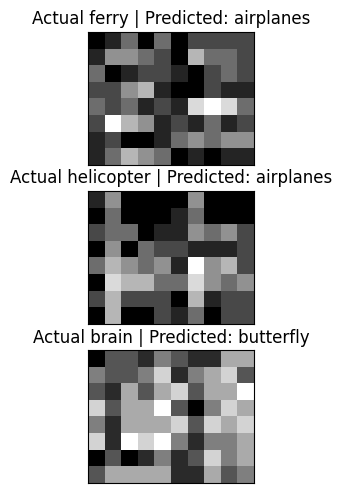

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                   precision    recall  f1-score   support

BACKGROUND_Google       0.44      0.44      0.44        18
            Faces       0.97      0.97      0.97        31
         Leopards       0.38      0.60      0.46         5
       Motorbikes       0.86      0.93      0.89        27
        accordion       1.00      1.00      1.00         6
        airplanes       0.88      0.97      0.92        30
           anchor       1.00      1.00      1.00         1
              ant       0.50      0.50      0.50         2
           barrel       0.00      0.00      0.00         3
             bass       0.00      0.00      0.00         4
           beaver       0.00      0.00      0.00         1
        binocular       0.00      0.00      0.00         0
           bonsai       0.33      0.75      0.46         4
            brain       0.50      0.50      0.50         4
     brontosaurus       0.00      0.00      0.00         1
           buddha       0.00      0.00      0.00       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6588459327290416
Recall: 0.618421052631579
F1-score: 0.6174005721558611
Top 3 Miss-Classified Classes.


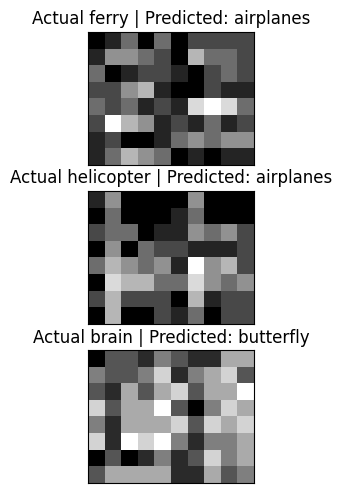

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                   precision    recall  f1-score   support

BACKGROUND_Google       0.19      0.44      0.26        18
            Faces       1.00      1.00      1.00        31
         Leopards       0.50      0.80      0.62         5
       Motorbikes       0.96      0.93      0.94        27
        accordion       1.00      1.00      1.00         6
        airplanes       0.82      0.90      0.86        30
           anchor       0.00      0.00      0.00         1
              ant       1.00      0.50      0.67         2
           barrel       0.00      0.00      0.00         3
             bass       0.33      0.50      0.40         4
           beaver       0.00      0.00      0.00         1
           bonsai       1.00      0.75      0.86         4
            brain       0.40      0.50      0.44         4
     brontosaurus       0.00      0.00      0.00         1
           buddha       0.67      0.50      0.57         4
        butterfly       0.25      0.33      0.29       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


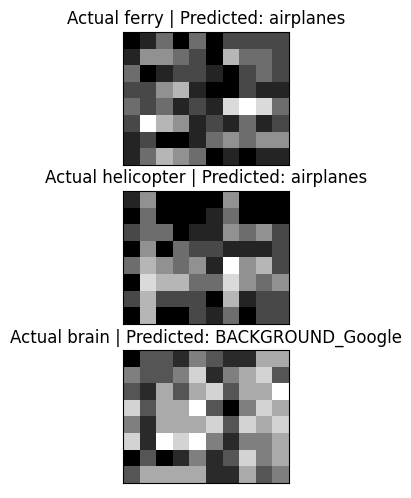

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                   precision    recall  f1-score   support

BACKGROUND_Google       0.12      0.39      0.18        18
            Faces       0.65      1.00      0.78        31
         Leopards       0.29      0.80      0.42         5
       Motorbikes       0.58      0.96      0.72        27
        accordion       1.00      0.67      0.80         6
        airplanes       0.62      0.97      0.75        30
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         3
             bass       0.00      0.00      0.00         4
           beaver       0.00      0.00      0.00         1
           bonsai       0.75      0.75      0.75         4
            brain       1.00      0.25      0.40         4
     brontosaurus       0.00      0.00      0.00         1
           buddha       1.00      0.25      0.40         4
        butterfly       0.50      0.33      0.40       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5405912005950706
Recall: 0.5394736842105263
F1-score: 0.5164836321636738
Top 3 Miss-Classified Classes.


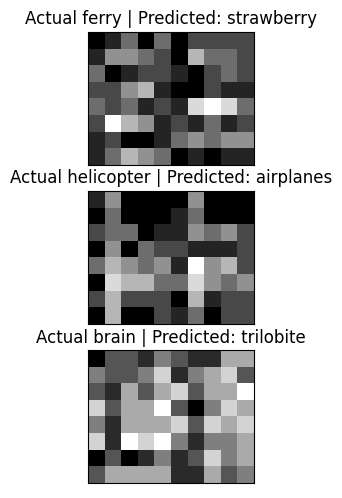

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                   precision    recall  f1-score   support

BACKGROUND_Google       0.27      0.17      0.21        18
            Faces       0.91      1.00      0.95        31
         Leopards       0.67      0.80      0.73         5
       Motorbikes       0.74      0.93      0.82        27
        accordion       1.00      0.17      0.29         6
        airplanes       0.81      0.97      0.88        30
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         3
             bass       0.00      0.00      0.00         4
           beaver       0.00      0.00      0.00         1
           bonsai       0.75      0.75      0.75         4
            brain       0.20      0.25      0.22         4
     brontosaurus       0.00      0.00      0.00         1
           buddha       0.67      0.50      0.57         4
        butterfly       1.00      0.33      0.50       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

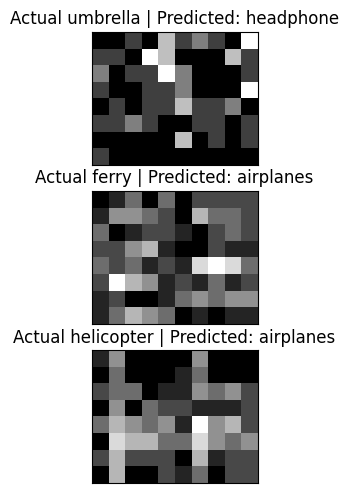

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                   precision    recall  f1-score   support

BACKGROUND_Google       0.37      0.56      0.44        18
            Faces       0.97      0.97      0.97        31
         Leopards       0.43      0.60      0.50         5
       Motorbikes       0.92      0.89      0.91        27
        accordion       1.00      1.00      1.00         6
        airplanes       0.77      0.90      0.83        30
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         3
             bass       0.50      0.25      0.33         4
           beaver       0.25      1.00      0.40         1
        binocular       0.00      0.00      0.00         0
           bonsai       0.50      0.50      0.50         4
            brain       0.33      0.25      0.29         4
     brontosaurus       0.00      0.00      0.00         1
           buddha       0.20      0.25      0.22       

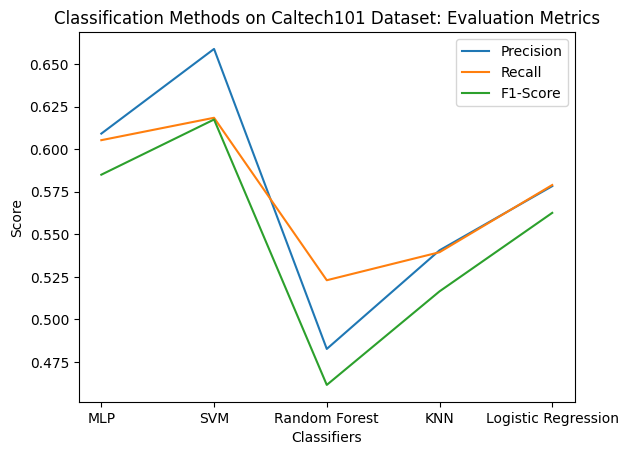

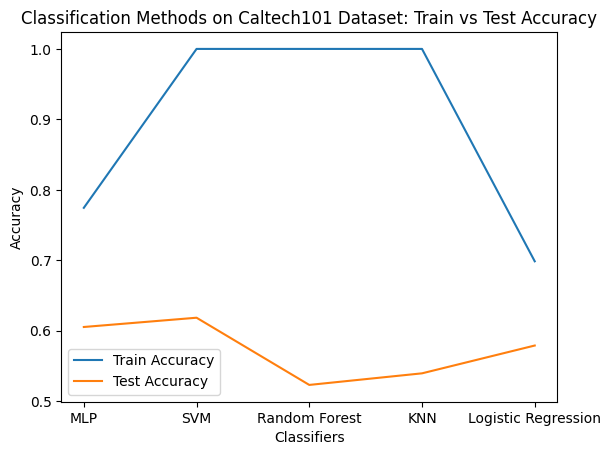

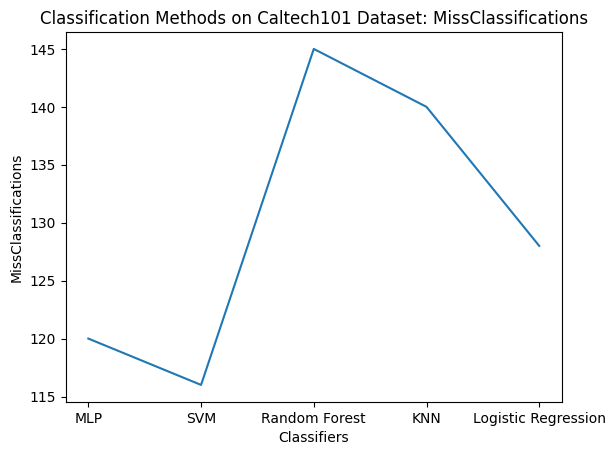

In [34]:
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun()

Main Menu
1. Run Classifiers with K-fold Strategy
2. Run Classifiers with Stratified K-fold Strategy
3. Run SVM with [3, 5, 10, 15, 20, 25, 30, 35, 40] images per class for training
4. Exit
Enter your choice: 2
using Stratified k-Fold Devision.
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.8169683257918552 
Test Accuracy for MLP is: 0.555921052631579
Number of images incorrectly classified for MLP is: 135
Precision: 0.5034496581646926
Recall: 0.555921052631579
F1-score: 0.5180322072067605
Loss difference observed Between train/test: 0.34257024416305293
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


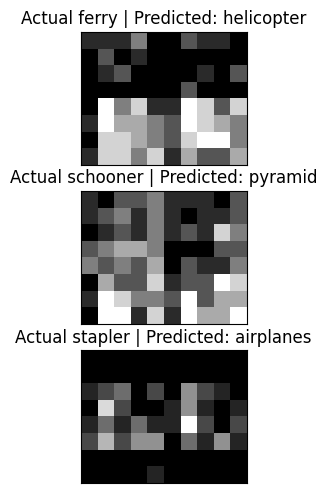

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

BACKGROUND_Google       0.40      0.25      0.31        16
            Faces       0.90      0.93      0.92        29
         Leopards       0.70      1.00      0.82         7
       Motorbikes       0.87      1.00      0.93        27
        accordion       0.00      0.00      0.00         2
        airplanes       0.90      1.00      0.95        26
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         2
             bass       0.00      0.00      0.00         2
           beaver       0.00      0.00      0.00         2
        binocular       0.00      0.00      0.00         1
           bonsai       0.33      0.50      0.40         4
            brain       0.50      0.67      0.57         3
     brontosaurus       0.00      0.00      0.00         2
           buddha       0.75      1.00      0.86       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5378768671773703
Recall: 0.5625
F1-score: 0.5318883954319527
Top 3 Miss-Classified Classes.


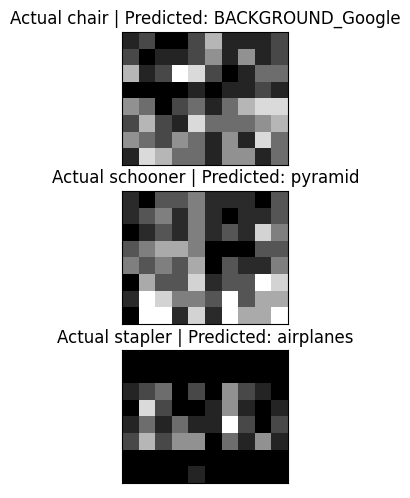

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

BACKGROUND_Google       0.21      0.50      0.29        16
            Faces       0.85      1.00      0.92        29
         Leopards       0.67      0.86      0.75         7
       Motorbikes       1.00      1.00      1.00        27
        accordion       1.00      1.00      1.00         2
        airplanes       0.81      1.00      0.90        26
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         2
             bass       0.33      0.50      0.40         2
           beaver       0.00      0.00      0.00         2
        binocular       0.00      0.00      0.00         1
           bonsai       0.22      0.50      0.31         4
            brain       0.20      0.33      0.25         3
     brontosaurus       0.00      0.00      0.00         2
           buddha       1.00      0.67      0.80       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


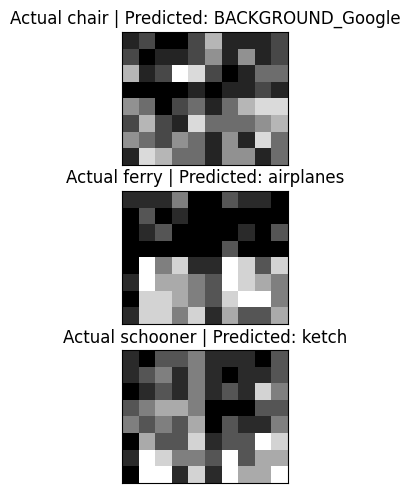

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

BACKGROUND_Google       0.12      0.38      0.18        16
            Faces       0.51      1.00      0.67        29
         Leopards       0.43      0.86      0.57         7
       Motorbikes       0.56      1.00      0.72        27
        accordion       1.00      1.00      1.00         2
        airplanes       0.65      1.00      0.79        26
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         2
             bass       0.00      0.00      0.00         2
           beaver       0.00      0.00      0.00         2
        binocular       0.00      0.00      0.00         1
           bonsai       0.00      0.00      0.00         4
            brain       0.67      0.67      0.67         3
     brontosaurus       0.00      0.00      0.00         2
           buddha       1.00      0.33      0.50       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


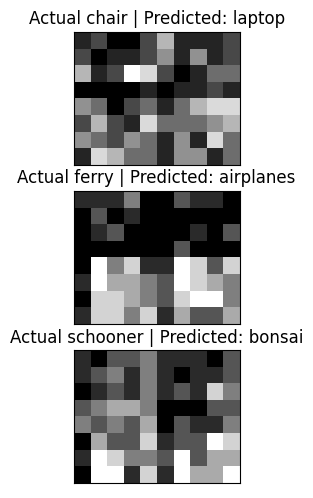

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

BACKGROUND_Google       0.30      0.19      0.23        16
            Faces       0.85      1.00      0.92        29
         Leopards       0.75      0.86      0.80         7
       Motorbikes       0.79      0.96      0.87        27
        accordion       1.00      0.50      0.67         2
        airplanes       0.71      0.92      0.80        26
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         2
             bass       1.00      0.50      0.67         2
           beaver       0.00      0.00      0.00         2
        binocular       0.00      0.00      0.00         1
           bonsai       0.33      0.25      0.29         4
            brain       0.29      0.67      0.40         3
     brontosaurus       0.00      0.00      0.00         2
           buddha       1.00      1.00      1.00       

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


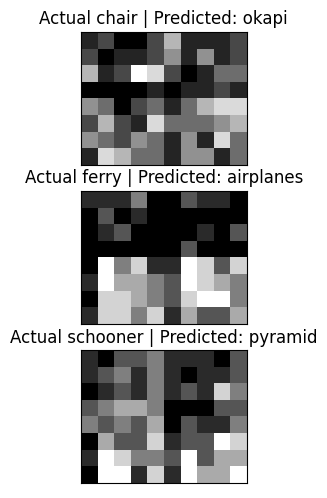

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

BACKGROUND_Google       0.20      0.25      0.22        16
            Faces       0.72      1.00      0.84        29
         Leopards       0.64      1.00      0.78         7
       Motorbikes       0.84      1.00      0.92        27
        accordion       0.00      0.00      0.00         2
        airplanes       0.87      1.00      0.93        26
           anchor       0.00      0.00      0.00         1
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         2
             bass       0.20      0.50      0.29         2
           beaver       1.00      0.50      0.67         2
        binocular       0.00      0.00      0.00         1
           bonsai       0.20      0.25      0.22         4
            brain       0.67      0.67      0.67         3
     brontosaurus       0.00      0.00      0.00         2
           buddha       1.00      0.33      0.50       

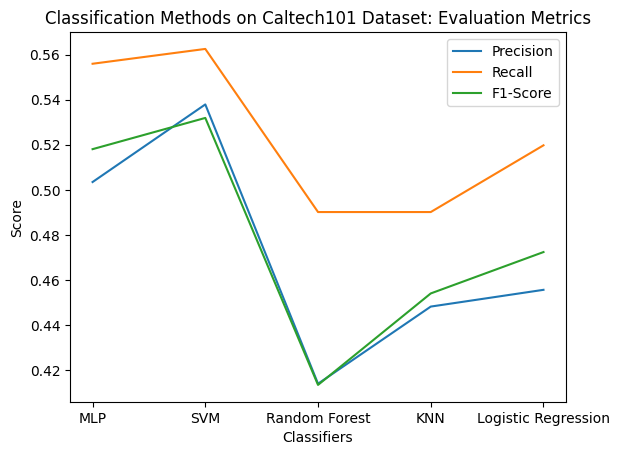

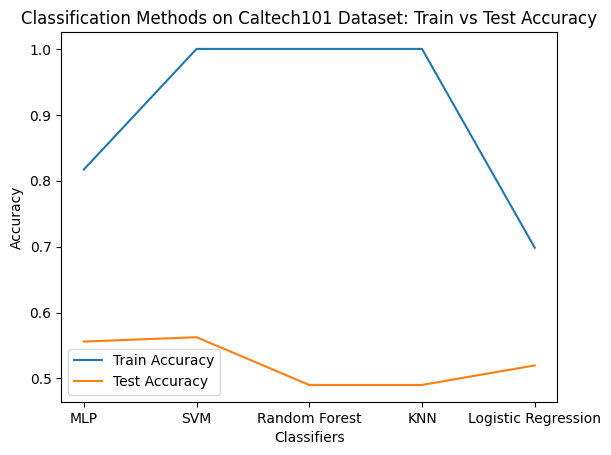

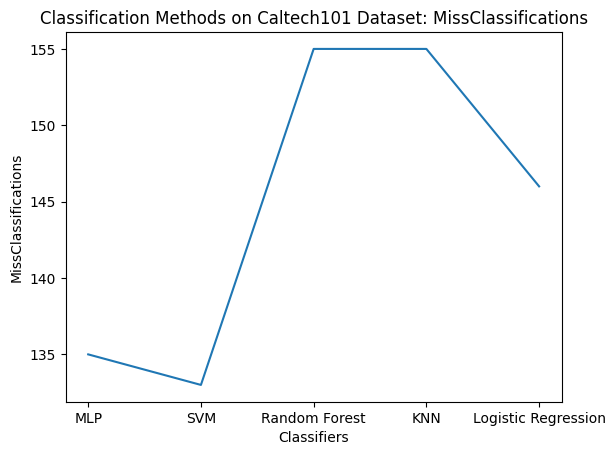

In [36]:
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun()

Main Menu
1. Run Classifiers with K-fold Strategy
2. Run Classifiers with Stratified K-fold Strategy
3. Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training
4. Exit
Enter your choice: 3
Run SVM with [3,5,10,15,20,25,30] images per class for training


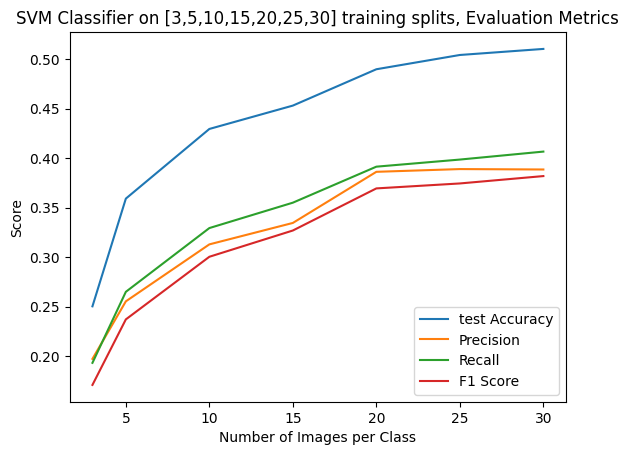

In [55]:
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun()

In [70]:
# Running Classification methods by removing the noise class
histogramData, image_classes=class_remove('BACKGROUND_Google',image_classes,histogramData)

Main Menu
1. Run Classifiers with K-fold Strategy
2. Run Classifiers with Stratified K-fold Strategy
3. Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training
4. Exit
Enter your choice: 1
using k-Fold Devision.
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.8918693371483071 
Test Accuracy for MLP is: 0.615916955017301
Number of images incorrectly classified for MLP is: 111
Precision: 0.6456675317185697
Recall: 0.615916955017301
F1-score: 0.6093109690619476
Loss difference observed Between train/test: 0.5032341702176426
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


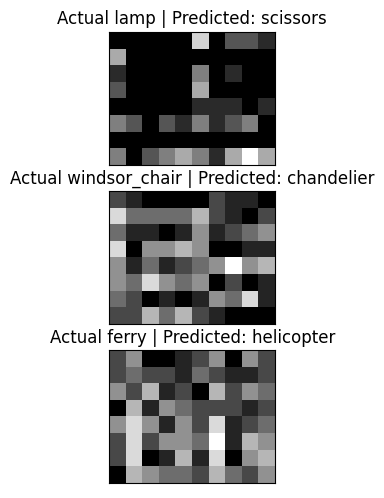

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                 precision    recall  f1-score   support

          Faces       0.91      1.00      0.95        29
       Leopards       0.83      0.83      0.83         6
     Motorbikes       1.00      1.00      1.00        29
      accordion       1.00      0.50      0.67         2
      airplanes       0.90      0.90      0.90        30
         anchor       0.00      0.00      0.00         1
            ant       0.00      0.00      0.00         0
         barrel       1.00      0.50      0.67         2
           bass       0.00      0.00      0.00         0
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         2
         bonsai       0.57      0.57      0.57         7
          brain       0.40      0.67      0.50         3
   brontosaurus       0.00      0.00      0.00         2
         buddha       0.50      1.00      0.67         2
      butterfly       0.33      0.40      0.36         5
         camera       0.50    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6323143726181174
Recall: 0.629757785467128
F1-score: 0.6076264708264951
Top 3 Miss-Classified Classes.


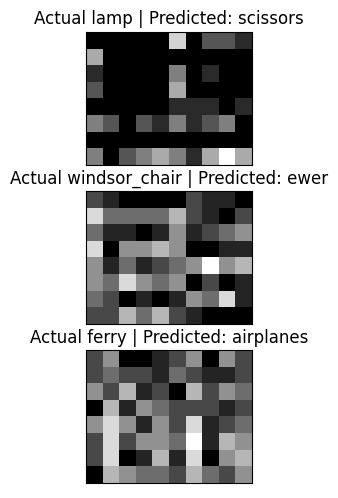

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                 precision    recall  f1-score   support

          Faces       0.91      1.00      0.95        29
       Leopards       0.57      0.67      0.62         6
     Motorbikes       0.94      1.00      0.97        29
      accordion       1.00      0.50      0.67         2
      airplanes       0.88      0.93      0.90        30
         anchor       0.00      0.00      0.00         1
            ant       0.00      0.00      0.00         0
         barrel       1.00      0.50      0.67         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         2
         bonsai       0.60      0.43      0.50         7
          brain       0.40      0.67      0.50         3
   brontosaurus       1.00      0.50      0.67         2
         buddha       0.50      1.00      0.67         2
      butterfly       0.33      0.20      0.25         5
         camera       0.50      1.00      0.67         1
         cannon       0.00    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


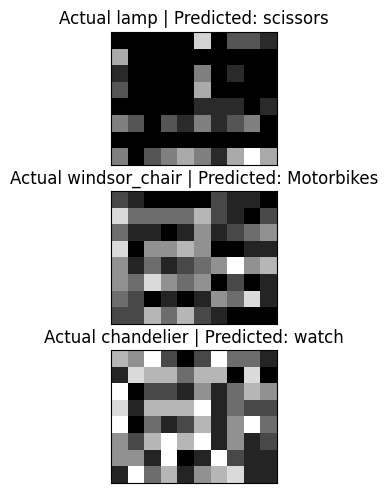

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                 precision    recall  f1-score   support

          Faces       0.46      1.00      0.63        29
       Leopards       0.36      0.83      0.50         6
     Motorbikes       0.55      1.00      0.71        29
      accordion       1.00      0.50      0.67         2
      airplanes       0.70      0.93      0.80        30
         anchor       0.00      0.00      0.00         1
         barrel       0.00      0.00      0.00         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         2
         bonsai       0.50      0.43      0.46         7
          brain       0.00      0.00      0.00         3
   brontosaurus       0.00      0.00      0.00         2
         buddha       1.00      0.50      0.67         2
      butterfly       0.33      0.20      0.25         5
         camera       0.00      0.00      0.00         1
         cannon       0.00      0.00      0.00         1
       car_side       0.67    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


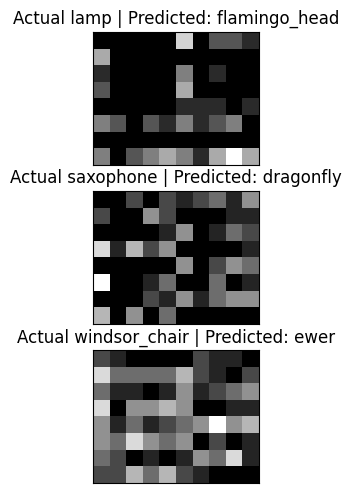

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                 precision    recall  f1-score   support

          Faces       0.93      0.97      0.95        29
       Leopards       0.56      0.83      0.67         6
     Motorbikes       0.78      1.00      0.88        29
      accordion       0.00      0.00      0.00         2
      airplanes       0.80      0.93      0.86        30
         anchor       0.00      0.00      0.00         1
         barrel       0.50      0.50      0.50         2
           bass       0.00      0.00      0.00         0
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         2
         bonsai       0.60      0.43      0.50         7
          brain       0.00      0.00      0.00         3
   brontosaurus       1.00      0.50      0.67         2
         buddha       0.50      0.50      0.50         2
      butterfly       0.00      0.00      0.00         5
         camera       1.00      1.00      1.00         1
         cannon       0.00    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

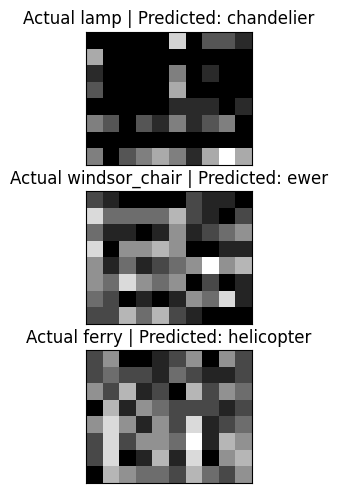

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_cla

                 precision    recall  f1-score   support

          Faces       0.94      1.00      0.97        29
       Leopards       0.67      0.67      0.67         6
     Motorbikes       0.80      0.97      0.88        29
      accordion       1.00      1.00      1.00         2
      airplanes       0.90      0.87      0.88        30
         anchor       0.00      0.00      0.00         1
            ant       0.00      0.00      0.00         0
         barrel       0.50      0.50      0.50         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         2
         bonsai       1.00      0.43      0.60         7
          brain       0.50      0.67      0.57         3
   brontosaurus       0.33      0.50      0.40         2
         buddha       1.00      0.50      0.67         2
      butterfly       0.00      0.00      0.00         5
         camera       0.00      0.00      0.00         1
         cannon       0.00    

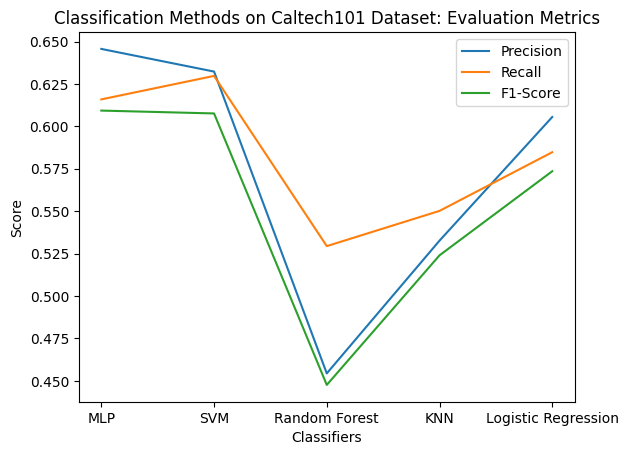

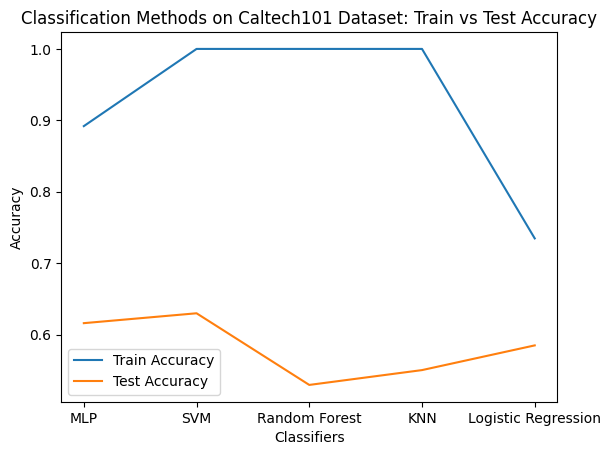

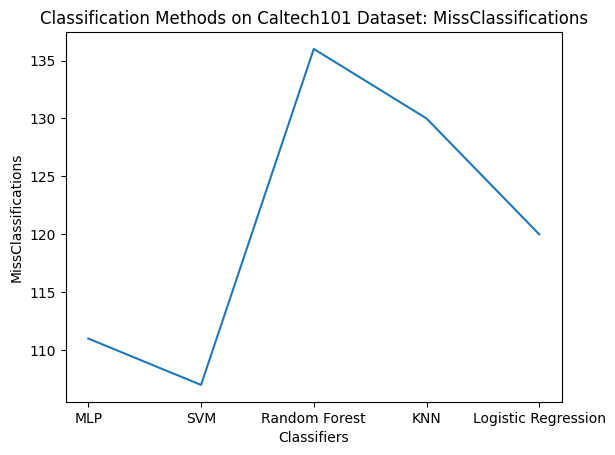

In [57]:
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun()

Main Menu
1. Run Classifiers with K-fold Strategy
2. Run Classifiers with Stratified K-fold Strategy
3. Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training
4. Exit
Enter your choice: 2
using Stratified k-Fold Devision.
Multi-layer Perceptron Classification.
Train Accuracy for MLP is: 0.8757749165474488 
Test Accuracy for MLP is: 0.6055363321799307
Number of images incorrectly classified for MLP is: 114
Precision: 0.5643197920879581
Recall: 0.6055363321799307
F1-score: 0.5723072013003926
Loss difference observed Between train/test: 0.26447605564514043
Top 3 Miss-Classified Classes.


C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


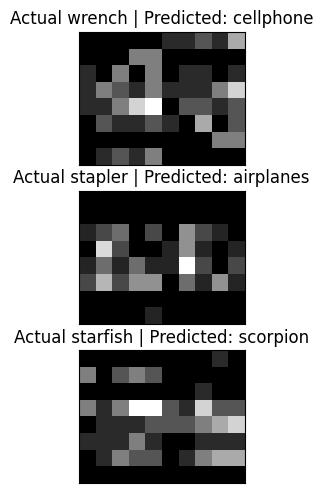

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          Faces       0.88      1.00      0.94        29
       Leopards       0.75      0.86      0.80         7
     Motorbikes       0.87      1.00      0.93        26
      accordion       0.00      0.00      0.00         2
      airplanes       0.93      0.96      0.95        27
         anchor       0.50      1.00      0.67         1
            ant       0.00      0.00      0.00         1
         barrel       0.00      0.00      0.00         1
           bass       0.33      0.50      0.40         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         1
         bonsai       0.40      0.50      0.44         4
          brain       0.67      0.67      0.67         3
   brontosaurus       0.00      0.00      0.00         1
         buddha       0.50      0.67      0.57         3
      butterfly       0.50      0.33      0.40         3
         camera       1.00    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6815944227589616
Recall: 0.6816608996539792
F1-score: 0.658061199645271
Top 3 Miss-Classified Classes.


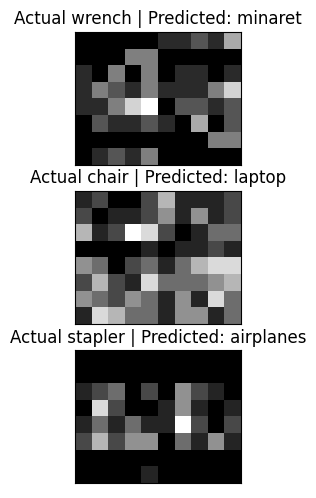

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          Faces       0.97      1.00      0.98        29
       Leopards       0.67      0.86      0.75         7
     Motorbikes       1.00      1.00      1.00        26
      accordion       1.00      0.50      0.67         2
      airplanes       0.93      1.00      0.96        27
         anchor       0.50      1.00      0.67         1
            ant       0.00      0.00      0.00         1
         barrel       0.00      0.00      0.00         1
           bass       0.25      0.50      0.33         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         1
         bonsai       0.29      0.50      0.36         4
          brain       0.33      0.67      0.44         3
   brontosaurus       0.00      0.00      0.00         1
         buddha       0.75      1.00      0.86         3
      butterfly       0.33      0.33      0.33         3
         camera       0.33    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


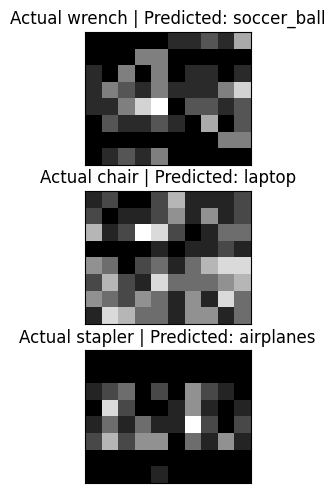

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          Faces       0.45      1.00      0.62        29
       Leopards       0.46      0.86      0.60         7
     Motorbikes       0.65      1.00      0.79        26
      accordion       1.00      1.00      1.00         2
      airplanes       0.69      1.00      0.82        27
         anchor       0.00      0.00      0.00         1
            ant       0.00      0.00      0.00         1
         barrel       0.00      0.00      0.00         1
           bass       0.00      0.00      0.00         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         1
         bonsai       0.33      0.50      0.40         4
          brain       0.20      0.33      0.25         3
   brontosaurus       0.50      1.00      0.67         1
         buddha       0.67      0.67      0.67         3
      butterfly       0.00      0.00      0.00         3
         camera       0.50    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


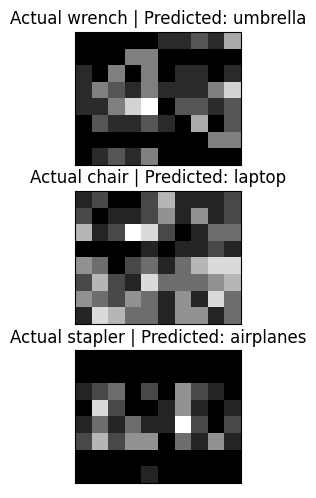

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          Faces       0.85      1.00      0.92        29
       Leopards       0.86      0.86      0.86         7
     Motorbikes       0.79      1.00      0.88        26
      accordion       1.00      0.50      0.67         2
      airplanes       0.90      1.00      0.95        27
         anchor       0.00      0.00      0.00         1
            ant       0.00      0.00      0.00         1
         barrel       0.00      0.00      0.00         1
           bass       0.00      0.00      0.00         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         1
         bonsai       0.33      0.50      0.40         4
          brain       0.40      0.67      0.50         3
   brontosaurus       0.33      1.00      0.50         1
         buddha       1.00      0.67      0.80         3
      butterfly       1.00      0.67      0.80         3
         camera       1.00    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


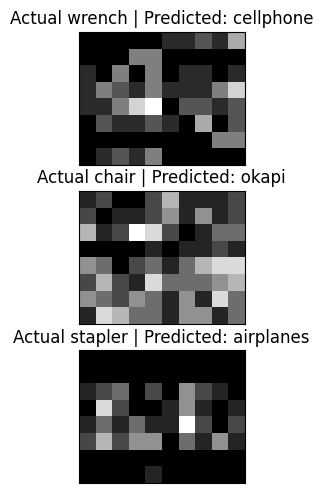

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          Faces       0.88      0.97      0.92        29
       Leopards       0.70      1.00      0.82         7
     Motorbikes       0.87      1.00      0.93        26
      accordion       0.00      0.00      0.00         2
      airplanes       0.90      0.96      0.93        27
         anchor       0.50      1.00      0.67         1
            ant       0.00      0.00      0.00         1
         barrel       0.00      0.00      0.00         1
           bass       0.00      0.00      0.00         2
         beaver       0.00      0.00      0.00         1
      binocular       0.00      0.00      0.00         1
         bonsai       0.67      0.50      0.57         4
          brain       0.40      0.67      0.50         3
   brontosaurus       0.00      0.00      0.00         1
         buddha       1.00      1.00      1.00         3
      butterfly       0.33      0.33      0.33         3
         camera       0.50    

C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cecil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


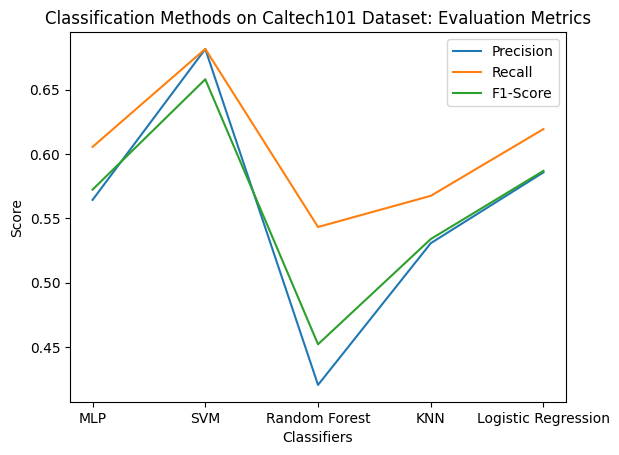

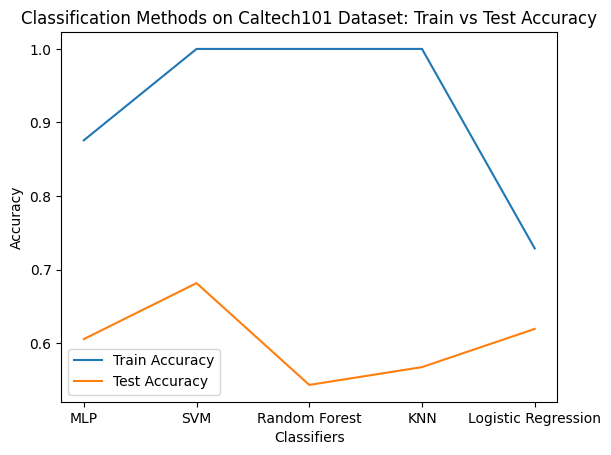

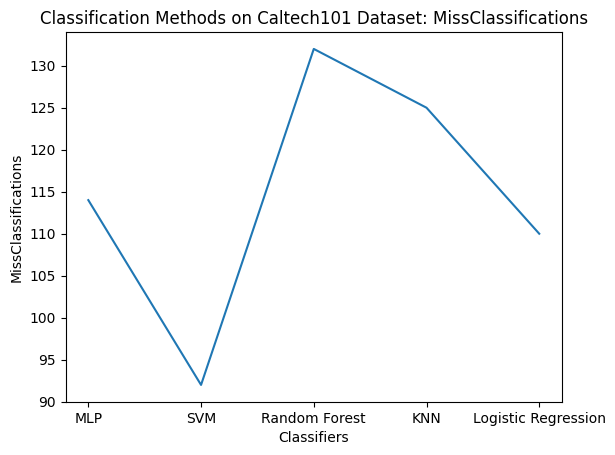

In [58]:
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun()

Main Menu
1. Run Classifiers with K-fold Strategy
2. Run Classifiers with Stratified K-fold Strategy
3. Run SVM with [3, 5, 10, 15, 20, 25, 30] images per class for training
4. Exit
Enter your choice: 3
Run SVM with [3,5,10,15,20,25,30] images per class for training


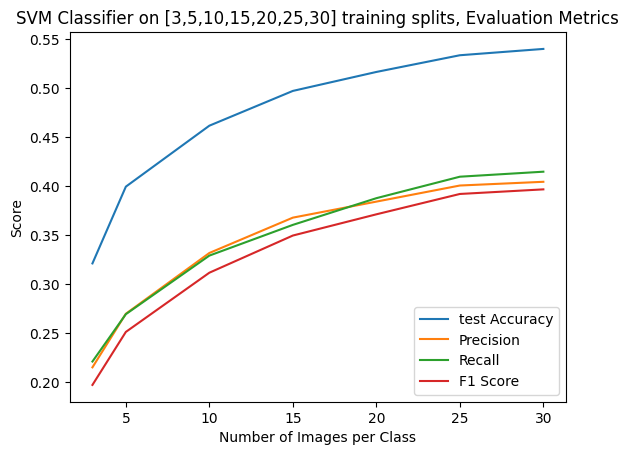

In [72]:
# Emptying to null
classifiers, classifiersMiss, train_acc, test_acc, num_wrong_clss, precisions, recalls, f1_scores = [], [], [], [], [], [], [], []
mainRun()